In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import cma
import subprocess
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa
from cma import CMAEvolutionStrategy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting


# Load dataset
dataset = np.loadtxt('dataset-GS1-GS10.txt').T

# Discard extreme values and nan values
# Find rows with any NaN values
rows_with_nan = np.isnan(dataset).any(axis=1)
# Delete rows with NaN values
data = dataset[~rows_with_nan, :]
Tw = 0.6756;
# Minus d for roughness
data[:,0] = data[:,0]-data[:,23];
data[18460:, 20] += 59  # Adjusting for 0-based indexing in Python
# Filter data, matching location
idy = (data[:, 0] > 0.02) & (data[:, 0] < 0.15)
data = data[idy, :]
idT = (data[:, 2] - Tw > 0)
data = data[idT, :]
condition = (data[:, 21] == 4) & (data[:, 22] == 4000)

data = data[~condition]
print('data size: ',data.shape)
# Reform input and output
input_data = np.column_stack((data[:, 0], data[:, 1], data[:, 3], data[:, 2] , np.full_like(data[:,1], Tw), data[:, 4],
                              data[:, 7], data[:, 6], data[:, 11], data[:, 12], data[:, 15]))

output_tauw = data[:, 18] * data[:, 0] / data[:, 4] / data[:, 1]
output_qw = data[:, 19] * data[:, 0] / (data[:, 2] - Tw) / data[:, 7]
index = data[:, 20]

data size:  (2692, 24)


In [2]:
# Define D_in matrix
D_in = np.matrix('1, 1, -3, 0, 0, -1, 1, 2, 1, 1, 0;0, -1, 0, 0,0, -1, -3, -2, 0, 0, 0; 0, 0, 1, 0,0, 1, 1, 0, 0, 0, 0; 0, 0, 0, 1, 1,0, -1, -1, 0, 0, 0')

print("D_in matrix:\n", D_in)
num_rows   = np.shape(D_in)[0]
num_cols   = np.shape(D_in)[1]
# Function to calculate basis matrices
def calc_basis(D_in, col_range):
    num_rows   = np.shape(D_in)[0]
    num_cols   = np.shape(D_in)[1]
    Din1, Din2 = D_in[:, :num_rows], D_in[:, num_rows:]
    basis_matrices = []
    for i in range(col_range):
        x2 = np.zeros((col_range, 1))
        x2[i, 0] = -1
        x1 = -inv(Din1) * Din2 * x2
        basis_matrices.append(np.vstack((x1, x2)))
    return np.asmatrix(np.array(basis_matrices))
# Generate basis matrices
num_basis      = D_in.shape[1] -matrix_rank(D_in)
basis_matrices = calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

D_in matrix:
 [[ 1  1 -3  0  0 -1  1  2  1  1  0]
 [ 0 -1  0  0  0 -1 -3 -2  0  0  0]
 [ 0  0  1  0  0  1  1  0  0  0  0]
 [ 0  0  0  1  1  0 -1 -1  0  0  0]]
Basis vectors:
matrix([[ 0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  3.,  1., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  2.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])


In [3]:
def calc_pi(a, basis_matrices,X):
    coef_pi = np.dot(a, basis_matrices)  # Computes the weighted sum of basis matrices
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat

def calc_pi_omega(coef_pi, X):
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat

def MI_d_binning(input, output, num_bins):
    #Calculate the mutual information between two matrices X and Y using histograms.
    #Fast! But not Accurate! Using it for approximation.
    #Parameters:
    #X (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #Y (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #num_bins (int): Number of bins for the histogram
    #Returns:
    #float: The mutual information between X and Y.
    def entropy_bin(X, num_bins):
        N, D = X.shape
        bins = [num_bins] * D
        hist, _ = np.histogramdd(X, bins=bins)
        hist = hist / np.sum(hist)  # Normalize to get probabilities
        positive_indices = hist > 0
        return -np.sum(hist[positive_indices] * np.log(hist[positive_indices]))

    mi = entropy_bin(input, num_bins) + entropy_bin(output, num_bins) - entropy_bin(np.hstack([input, output]), num_bins)
    return mi

def MI_input_output(para,basis_matrices,X,Y,num_basis,num_inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')  # Treat warnings as errors
        a_list = [tuple(para[i*num_basis:(i+1)*num_basis]) for i in range(num_inputs)]
        try:
            pi_list = [calc_pi(a, basis_matrices, X) for a in a_list]
            pi = np.column_stack(pi_list)
        except RuntimeWarning:
            return random.uniform(1e6, 1e10)  # Return a large positive value in case of RuntimeWarning
    
    if np.any(np.isnan(pi)):
        return random.uniform(1e6, 1e10)  # Return a large positive value
    
    Y = Y.reshape(-1, 1)
    MI = MI_d_binning(np.array(pi), np.array(Y), 10)
    #MI = KraskovMI1_nats(np.array(pi), np.array(Y), 5)
    return -MI

def KraskovMI1_nats( x, y, k : int = 1 ):
    '''Compute the mutual information using the Kraskov estimator (approach
    1 in Kraskov et al. (2004))
    Parameters
        x:  np.ndarray
            [ N, dim_x ] First variable of dimension "dim_x" with "N" samples
            per dimension
        y:  np.ndarray
            [ N, dim_x ] second variable of dimension "dim_x" with "N" samples
            per dimension
        
        k:  int
            Nearest-neighbor ( >= 1 )
    '''

    N, dim = x.shape 
  
    V = np.hstack([ x, y ])

    # Init query tree
    kdtree = scispa.KDTree( V )
    ei, _ = kdtree.query( V, k + 1, p = np.infty)
    # infty norm is gonna give us the maximum distance (x-dir or y-dir)
    dM = ei[:,-1] 
    
    kdtree_x = scispa.KDTree( x )
    kdtree_y = scispa.KDTree( y )

    nx = kdtree_x.query_ball_point( x, dM , p = np.infty, return_length = True)
    ny = kdtree_y.query_ball_point( y, dM , p = np.infty, return_length = True)

    # we do not add + 1 because it is accounted in query_ball_point
    ave = ( scis.psi( nx ) + scis.psi( ny ) ).mean()

    return scis.psi(k) - ave + scis.psi(N)

In [4]:
# Define the optimization parameters
num_input = 2
num_para = num_basis * num_input
print('num of parameters:', num_para)

lower_bounds = [-2] * num_para
upper_bounds = [2] * num_para
bounds = [lower_bounds, upper_bounds]

options = {
    'bounds': bounds,
    'maxiter': 50000,
    'tolx': 1e-8,
    'tolfun': 1e-8,
    'popsize': 50,
    'maxfevals': 1e4 * num_para
}

# CMA-ES optimization for output_tauw
es_tauw = CMAEvolutionStrategy([0.1] * num_para, 0.5, options)
while not es_tauw.stop():
    solutions = es_tauw.ask()
    es_tauw.tell(solutions, [MI_input_output(x, basis_matrices, input_data, output_tauw, num_basis, num_input) for x in solutions])
    es_tauw.disp()
es_tauw.result_pretty()
optimized_params_tauw = es_tauw.result.xbest
optimized_MI_tauw = es_tauw.result.fbest
print('Optimized_params_tauw', optimized_params_tauw)
print('Optimized_MI_tauw', optimized_MI_tauw)

# CMA-ES optimization for output_qw
es_qw = CMAEvolutionStrategy([0.1] * num_para, 0.5, options)
while not es_qw.stop():
    solutions = es_qw.ask()
    es_qw.tell(solutions, [MI_input_output(x, basis_matrices, input_data, output_qw, num_basis, num_input) for x in solutions])
    es_qw.disp()
es_qw.result_pretty()
optimized_params_qw = es_qw.result.xbest
optimized_MI_qw = es_qw.result.fbest
print('Optimized_params_qw', optimized_params_qw)
print('Optimized_MI_qw', optimized_MI_qw)

num of parameters: 14
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 14 (seed=996561, Tue Nov  5 12:47:18 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -6.386438748138268e-01 1.0e+00 4.66e-01  4e-01  5e-01 0:00.1
    2    100 -9.431904069166261e-01 1.2e+00 6.09e-01  6e-01  7e-01 0:00.1
    3    150 -7.373592801779054e-01 1.5e+00 6.35e-01  6e-01  7e-01 0:00.2
   42   2100 -1.298490618109294e+00 9.0e+00 2.00e-01  1e-01  2e-01 0:03.2
  100   5000 -1.364843455821696e+00 4.2e+01 2.44e-02  6e-03  2e-02 0:06.7
  179   8950 -1.371472045521075e+00 2.3e+02 3.39e-03  2e-04  4e-03 0:11.4
termination on tolfunhist=1e-12
final/bestever f-value = -1.371472e+00 -1.371472e+00 after 8950/8674 evaluations
incumbent solution: [ 0.00355474  1.89853013 -0.92531175  1.00147674 -0.39225412 -0.83888998
 -0.83776227  0.27284398 ...]
std deviations: [0.00060711 0.00227242 0.00200071 0.00202053 0.00241737 0.00257617
 0.0003871  0.00018944 ...]
Optimized_params_tauw

In [5]:
# Extract and process a_list for output_tauw
a_list_tauw = [tuple(optimized_params_tauw[i * num_basis:(i + 1) * num_basis]) for i in range(num_input)]

omega_tauw = []
for a in a_list_tauw:
    max_abs_value = np.max(np.abs(a))
    normalized_a = a / max_abs_value
    rounded_normalized_a = np.round(normalized_a, 2)
    coef_pi              = np.dot(rounded_normalized_a,basis_matrices)
    omega_tauw.append(np.round(coef_pi[0],2))
for i, normalized_coef_pi in enumerate(omega_tauw):
    print(f'coef_pi_tauw{i + 1}', normalized_coef_pi)

input_tauw_list = [calc_pi_omega(np.array(omega), input_data) for omega in omega_tauw]
input_tauw = np.column_stack(input_tauw_list)
# Extract and process a_list for output_qw
a_list_qw = [tuple(optimized_params_qw[i * num_basis:(i + 1) * num_basis]) for i in range(num_input)]

omega_qw = []
for a in a_list_qw:
    max_abs_value = np.max(np.abs(a))
    normalized_a = a / max_abs_value
    rounded_normalized_a = np.round(normalized_a, 2)
    coef_pi              = np.dot(rounded_normalized_a,basis_matrices)
    omega_qw.append(np.round(coef_pi[0],2))

for i, normalized_coef_pi in enumerate(omega_qw):
    print(f'coef_pi_qw{i + 1}', normalized_coef_pi)

input_qw_list = [calc_pi_omega(np.array(omega), input_data) for omega in omega_qw]
input_qw = np.column_stack(input_qw_list)


coef_pi_tauw1 [[-0.14  0.59  0.51 -0.04  0.   -1.    0.49 -0.53  0.21  0.44  0.44]]
coef_pi_tauw2 [[ 0.38  0.56  0.52  0.12 -0.14 -0.1  -0.42  0.4   1.   -0.86  0.02]]
coef_pi_qw1 [[ 0.04  0.71  0.59 -0.56  0.5  -1.    0.41 -0.47  0.67 -0.12  0.12]]
coef_pi_qw2 [[ 1.06  0.95  1.11  0.89 -0.81 -1.   -0.11  0.19 -0.51  0.56 -0.07]]


In [6]:
omega_tauw = np.squeeze(omega_tauw)
omega_qw = np.squeeze(omega_qw)
basis_matrices_new = np.array([
    [0,     0,     0,     1,    -1,     0,     0,     0,     0,     0,    0],
    [1,     1,     1,     0,     0,    -1,     0,     0,     0,     0,    0],
    [0,     1,     0,  -0.5,     0,     0,     0,  -0.5,     0,     0,    0],
    [0,     0,     0,     0,     0,     1,    -1,     1,     0,     0,    0],
    [1,     0,     0,     0,     0,     0,     0,     0,    -1,     0,    0],
    [1,     0,     0,     0,     0,     0,     0,     0,     0,    -1,    0],
    [0,     0,     0,     0,     0,     0,     0,     0,     0,     0,   -1]
])

basis_matrices_new_T = basis_matrices_new.T
gamma_tauw, _, _, _ = np.linalg.lstsq(basis_matrices_new_T, omega_tauw.T, rcond=None)
gamma_tauw = np.array(gamma_tauw.T)
gamma_tauw = np.round(gamma_tauw, 1)

gamma_qw, _, _, _ = np.linalg.lstsq(basis_matrices_new_T, omega_qw.T, rcond=None)
gamma_qw = np.array(gamma_qw.T)
gamma_qw = np.round(gamma_qw, 1)
variables_tauw = ['{(T_1/T_w)}', 'Re_1', 'M_1', 'Pr_1', '{(y_1/k_{rms})}', '{(y_1/Ra)}', 'ES']
variables_qw = ['{(T_1/T_w)}', 'Re_1', 'M_1', 'Pr_1', '{(y_1/k_{rms})}', '{(y_1/Ra)}', 'ES']

def create_labels(omega, variables):
    labels = []
    for row in omega:
        positive_part = ''
        negative_part = ''
        for i, value in enumerate(row):
            value = float(value)  
            if value > 0:
                if positive_part == '':
                    positive_part = f"{variables[i]}^{{{value}}}"
                else:
                    positive_part += f" \\cdot {variables[i]}^{{{value}}}"
            elif value < 0:
                if negative_part == '':
                    negative_part = f"{variables[i]}^{{{-value}}}"
                else:
                    negative_part += f" \\cdot {variables[i]}^{{{-value}}}"
        if negative_part == '':
            labels.append(f"${positive_part}$")
        elif positive_part == '':
            labels.append(f"$\\frac{{1}}{{{negative_part}}}$")
        else:
            labels.append(f"$\\frac{{{positive_part}}}{{{negative_part}}}$")
    return labels

tauw_lab = create_labels(gamma_tauw, variables_tauw)
qw_lab = create_labels(gamma_qw, variables_qw)

# Print the labels
for j, label in enumerate(tauw_lab):
    print(f'tauw_lab[{j}] = {label}')
for j, label in enumerate(qw_lab):
    print(f'qw_lab[{j}] = {label}')


tauw_lab[0] = $\frac{Re_1^{0.5} \cdot M_1^{0.1}}{Pr_1^{0.5} \cdot {(y_1/k_{rms})}^{0.2} \cdot {(y_1/Ra)}^{0.4} \cdot ES^{0.4}}$
tauw_lab[1] = $\frac{{(T_1/T_w)}^{0.1} \cdot Re_1^{0.5} \cdot Pr_1^{0.4} \cdot {(y_1/Ra)}^{0.9}}{{(y_1/k_{rms})}^{1.0}}$
qw_lab[0] = $\frac{Re_1^{0.6} \cdot M_1^{0.1} \cdot {(y_1/Ra)}^{0.1}}{{(T_1/T_w)}^{0.5} \cdot Pr_1^{0.4} \cdot {(y_1/k_{rms})}^{0.7} \cdot ES^{0.1}}$
qw_lab[1] = $\frac{{(T_1/T_w)}^{0.8} \cdot Re_1^{1.1} \cdot Pr_1^{0.1} \cdot {(y_1/k_{rms})}^{0.5} \cdot ES^{0.1}}{M_1^{0.2} \cdot {(y_1/Ra)}^{0.6}}$


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


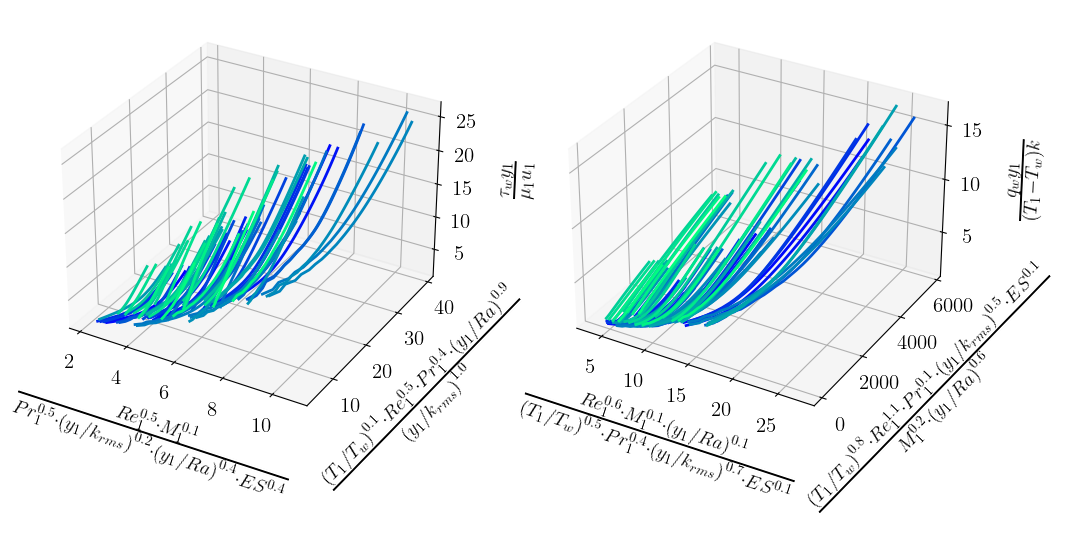

In [12]:
def plot_data_subfigures(input_data1, output_data1, labels1, zlabel1,
                         input_data2, output_data2, labels2, zlabel2, filename_base):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})  
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['text.usetex'] = True  

    for i, id in enumerate(ids):
        id_mask = (index == id)
        ax1.plot(input_data1[id_mask, 0], input_data1[id_mask, 1], output_data1[id_mask], 
                 color=colors[i], linewidth=2)
    ax1.set_xlabel(labels1[0], fontsize=20, labelpad=15)
    ax1.set_ylabel(labels1[1], fontsize=20, labelpad=15)
    ax1.set_zlabel(zlabel1, fontsize=20, labelpad=15)
    ax1.xaxis.set_tick_params(width=1, labelsize=15)
    ax1.yaxis.set_tick_params(width=1, labelsize=15)
    ax1.zaxis.set_tick_params(width=1, labelsize=15)
    ax1.grid(True)

    for i, id in enumerate(ids):
        id_mask = (index == id)
        ax2.plot(input_data2[id_mask, 0], input_data2[id_mask, 1], output_data2[id_mask], 
                 color=colors[i], linewidth=2)
    ax2.set_xlabel(labels2[0], fontsize=20, labelpad=15)
    ax2.set_ylabel(labels2[1], fontsize=20, labelpad=15)
    ax2.set_zlabel(zlabel2, fontsize=20, labelpad=15)
    ax2.xaxis.set_tick_params(width=1, labelsize=15)
    ax2.yaxis.set_tick_params(width=1, labelsize=15)
    ax2.zaxis.set_tick_params(width=1, labelsize=15)
    ax2.grid(True)

    # Save the figure in both EPS and PNG formats
    plt.savefig(f"{filename_base}.eps", dpi=300, bbox_inches='tight')
    #plt.savefig(f"{filename_base}.png", dpi=300, bbox_inches='tight')
    plt.show()

ids = np.unique(index)
colors = plt.cm.winter(np.linspace(0, 1, len(ids)))
plot_data_subfigures(
    input_tauw, output_tauw, tauw_lab, r'$\frac{\tau_w y_1  } {\mu_1 u_1}$',
    input_qw, output_qw, qw_lab, r'$\frac{q_w y_1}{(T_1 -T_w) k}$',
    'tauw_qw_dimensionless'
)
